# **Курсовая работа**

# **Определение вероятности подключения услуги**

## **Импорт библиотек**

In [4]:
import os
import dill
import pandas as pd
import numpy as np
import dask.dataframe as dd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier

import matplotlib.pyplot as plt

Пути к файлам

In [5]:
PATH_TRAIN = './load/data_train.csv'
PATH_TEST = './load/data_test.csv'
PATH_FEATURES = './load/features.csv'

## **Загрузка и подготовка данных**

### Выделение признаков из датасета features для пользователей, которые есть в data_train/data_test

Загрузка файлов

In [6]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

In [7]:
df_features = dd.read_csv(PATH_FEATURES, sep='\t')

common_users = pd.concat([df_train, df_test]).id.unique()
df_features = df_features[df_features.id.isin(common_users)].compute()
del common_users

df_features.drop('Unnamed: 0', axis=1, inplace=True)
df_features.head(2)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### Объединение features с data_train/data_test

Функция для объединения датасетов

In [8]:
def transform(df: pd.DataFrame, df_features: pd.DataFrame, isTrain: bool) -> pd.DataFrame:
    print(f"Размер датасета перед преобразованием: {df.shape}")
    
    df = pd.merge(df, df_features, how='left', on='id')
    
    
    if isTrain:
        df = df[abs(df.buy_time_x - df.buy_time_y) > 172800]
    
    df.drop(['Unnamed: 0', 'buy_time_y'], axis=1, inplace=True)
    df.rename(columns={"buy_time_x": "buy_time"}, inplace=True)
    
    print(f"Размер датасета после преобразования: {df.shape}")
    return df

Группировка данных по id пользователя

In [9]:
df_features_groupby = df_features.groupby('id').first()

Тренировочный датасет после объединения с features

In [10]:
df_train = transform(df_train, df_features_groupby, True)
df_train.head(2)

Размер датасета перед преобразованием: (831653, 5)
Размер датасета после преобразования: (793804, 257)


,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0


Тестовый датасет после объединения с features. Сохранение датасета в файл

In [11]:
df_test = transform(df_test, df_features_groupby, False)
df_test.to_csv('./data_test.csv')
df_test.head(2)

Размер датасета перед преобразованием: (71231, 4)
Размер датасета после преобразования: (71231, 256)


,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2.0,1548018000,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,17.81382,...,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2000860,4.0,1548018000,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-254.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


## **Работа с признаками**

In [12]:
RANDOM_STATE = 100

Функция для подсчёта количества признаков

In [13]:
def get_features(X: pd.DataFrame):
    assert isinstance(X, pd.DataFrame)
    
    X_nunique = X.apply(lambda x: x.nunique(dropna=False))

    f_init = set(X_nunique.index.tolist())
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    f_other = f_init - (f_numeric | f_const)
    f_binary = set(X.loc[:, f_other].columns[(
        (X.loc[:, f_other].max() == 1) & \
        (X.loc[:, f_other].min() == 0) & \
        (X.loc[:, f_other].isnull().sum() == 0)
    )])
    f_other = f_other - f_binary
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_all = f_binary | f_categorical | f_numeric

    print('Всего признаков:', len(f_init))
    print('Константные признаки:', len(f_const))
    print('Бинарные признаки:', len(f_binary))
    print('Категориальные признаки:', len(f_categorical))
    print('Вещественные признаки:', len(f_numeric))
    
    assert(len(f_init) == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

    return list(f_binary), list(f_categorical), list(f_numeric), list(f_all)

Разбиение датасета на test/train. Вывод количества признаков

In [14]:
X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=100,
    shuffle=True,
    stratify=y,
)

f_binary, f_categorical, f_numeric, f_all = get_features(X_train)
del df_train, X, y

Всего признаков: 255
Константные признаки: 5
Бинарные признаки: 0
Категориальные признаки: 1
Вещественные признаки: 249


## **Подбор модели. Построение пайплайна**

Проверяются три различные модели:  логистическая регрессия, SGD классификатор и градиентный бустинг

Функция для расчёта метрик

In [15]:
def evaluate_model(model, X_test, y_test):
    y_test_pred = model.predict_proba(X_test)[:,1]
    plot_confusion_matrix(model, X_test, y_test)
    print(f'{classification_report(y_test, y_test_pred > 0.5)}\n\n')

Класс для выбора колонки

In [16]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("Датасет не содержит следующие колонки: %s" % cols_error)

Построение пайплайна

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    184026
         1.0       0.29      0.00      0.00     14425

    accuracy                           0.93    198451
   macro avg       0.61      0.50      0.48    198451
weighted avg       0.88      0.93      0.89    198451



SGDClassifier
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    184026
         1.0       0.38      0.01      0.02     14425

    accuracy                           0.93    198451
   macro avg       0.65      0.51      0.49    198451
weighted avg       0.89      0.93      0.89    198451



GradientBoostingClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    184026
         1.0       0.67      0.27      0.38     14425

    accuracy                           0.94    198451
   macro avg       0.81      0.63      0.68    198451
weighted a

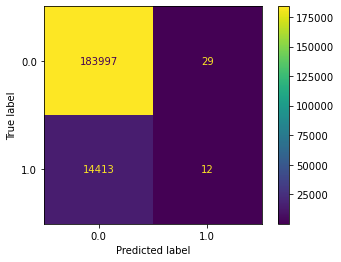

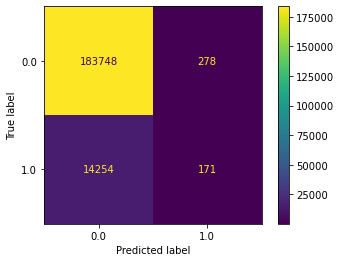

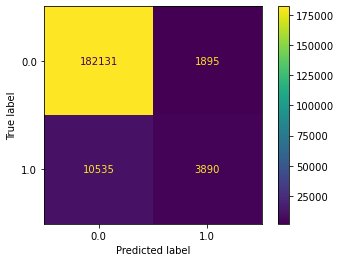

In [18]:
# Пайплайн предобработки данных
# Вещественные признаки масштабируются
# Для категориальных используем OneHot преобразование
train_pipeline = make_pipeline(
    FeatureSelector(columns=f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            FeatureSelector(columns=f_numeric),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            FeatureSelector(columns=f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ]),
    SelectFromModel(LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')),
)
# Словарь с моделями и их гиперпараметрами
models = {
    0: {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        ),
    },
    1: {
        'name': 'SGDClassifier',
        'estimator': SGDClassifier(
            random_state=RANDOM_STATE,
            loss='log',
        ),
    },
    2: {
        'name': 'GradientBoostingClassifier',
        'estimator': GradientBoostingClassifier(
            random_state=RANDOM_STATE,
        )
    },
}
# Обучение моделей
for key,value in models.items():
    
    print(f'{models[key]["name"]}')
    model = make_pipeline(
        train_pipeline,
        models[key]["estimator"],
    )
    model.fit(X_train, y_train)
    
    evaluate_model(model, X_test, y_test)

Наиболее высокую метрику f1-score показывает модель градиентного бустинга, поэтому далее будем использовать её

## **Построение окончательной модели**

Построение пайплайна на основе модели градиентрого бустинга

In [19]:
final_model = make_pipeline(
    train_pipeline,
    GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        learning_rate=0.3,
        n_estimators=300,
        min_samples_split=2,
        max_depth=8,
    )
)

final_model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureselector',
                                  FeatureSelector(columns=['95', '159', '47',
                                                           '166', '247', '181',
                                                           '46', '154', '61',
                                                           '192', '245', '191',
                                                           '201', '131', '92',
                                                           '233', '178', '235',
                                                           '112', '210', '135',
                                                           '77', '132', '242',
                                                           '169', '60', '195',
                                                           '50', '7', '194', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('num

## **Результаты работы окончательной модели**

Расчёт метрик

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96    184026
         1.0       0.51      0.34      0.41     14425

    accuracy                           0.93    198451
   macro avg       0.73      0.66      0.69    198451
weighted avg       0.92      0.93      0.92    198451





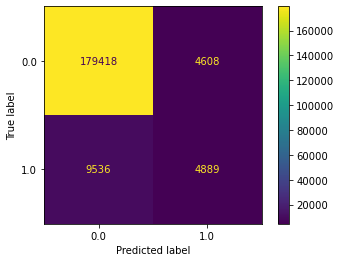

In [20]:
evaluate_model(final_model, X_test, y_test)

Построение матрицы ошибок

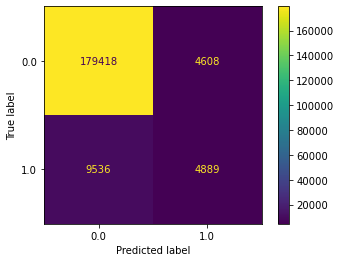

In [21]:
plot_confusion_matrix(final_model, X_test, y_test)
plt.show()

Построение ROC-AUC и PR кривых

AUC_PR = 0.436
AUC_ROC = 0.917


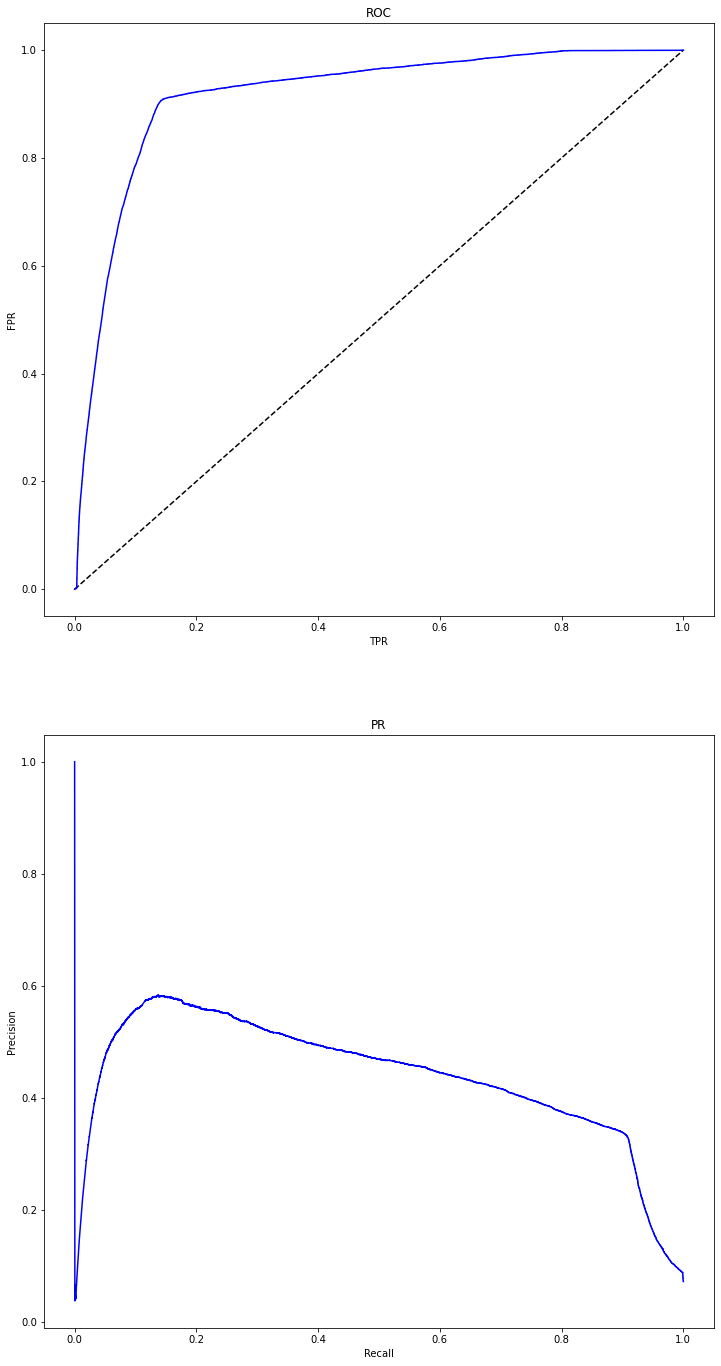

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

y_test_pred = final_model.predict_proba(X_test)[:,1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("AUC_PR = %.3f" % auc(recall, precision))
print("AUC_ROC = %.3f" % auc(fpr, tpr))

## **Сохранение окончательной модели**

In [23]:
with open('model.dill', 'wb') as file:
    dill.dump(final_model, file)